In [1]:
import imageio
import torch
from IPython.display import clear_output
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
%matplotlib inline
import numpyro
import pyro.distributions as dist
import numpyro
import numpyro.distributions as n_dist
import PyQt5
import skimage.morphology as morph
import skimage

from dataProcessing import *

%matplotlib inline

In [2]:
### Load data ####
timeResolution = np.array([25, 16, 17, 15, 15, 17, 14])
spatialDownsamplingFactor=4
noVideos=2

dataPath='data/usliverseq-mp4'
videoList = loadData(dataPath,timeResolution,spatialDownsamplingFactor=spatialDownsamplingFactor,noVideos=noVideos)

### Get affine transformation ###

ptsArray = np.load('transPts.npz')["arr_0"]/spatialDownsamplingFactor

# We agree on a reference video which all other videos are transformed to, video 2, i.e. video index 1
refIdx=1

videoTransList = getAffineTrans(videoList,ptsArray,refIdx)

### Mask everything outside field of view and smooth pixels out ###

# Define smoothing parameter sigma
sigma=(0,3,3) # Do not smooth over temporal dim, only spatial
videoTransMaskList, morphsInput, vidMasks = maskAndSmooth(videoTransList,sigma)


Loading video 1/2..
    Spatial resolution before spatial downsampling: 712 x 480
    No. of frames before temporal downsampling: 4372
    Downsampling from 25 to 14 frames per second
    Spatial resolution before spatial downsampling: 178 x 120
    No. of frames after temporal downsampling: 2436

Loading video 2/2..
    Spatial resolution before spatial downsampling: 700 x 480
    No. of frames before temporal downsampling: 4625
    Downsampling from 16 to 14 frames per second
    Spatial resolution before spatial downsampling: 175 x 120
    No. of frames after temporal downsampling: 4046



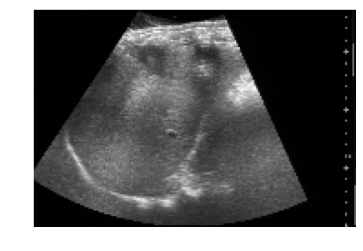

In [12]:
# Run example of video


videoIdx = 0 # Choose video to visualize
noFrames = 100 # Choose first noFrames to visualize

vidShow=videoList[videoIdx][:noFrames]
for i in range(noFrames):
    plt.imshow(vidShow[i],cmap='gray')
    plt.show()
    clear_output(wait=True)

Text(0.5, 1.0, 'Final processed video')

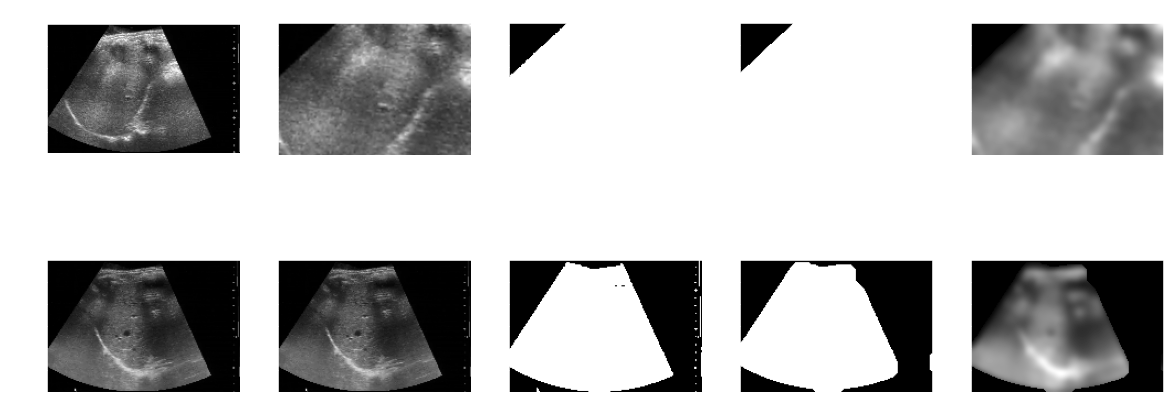

In [3]:
fig,ax = plt.subplots(len(videoList),5,figsize=(20,4*len(videoList)))
for vidIdx in range(len(videoList)):
        ax[vidIdx,0].imshow(videoList[vidIdx][0],cmap='gray')
        ax[vidIdx,1].imshow(videoTransList[vidIdx][0],cmap='gray')
        ax[vidIdx,2].imshow(morphsInput[vidIdx],cmap='gray')
        ax[vidIdx,3].imshow(vidMasks[vidIdx],cmap='gray')
        ax[vidIdx,4].imshow(videoTransMaskList[vidIdx][0],cmap='gray')
        ax[vidIdx,0].set_ylabel(f'Video {vidIdx+1}')
ax[0,0].set_title('Original video')
ax[0,1].set_title('Affine transformed video')
ax[0,2].set_title('Thresholded video')
ax[0,3].set_title('Mask')
ax[0,4].set_title('Final processed video')


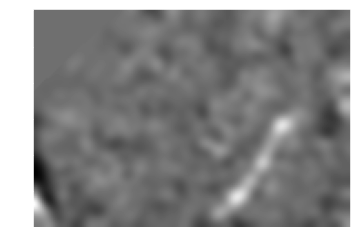

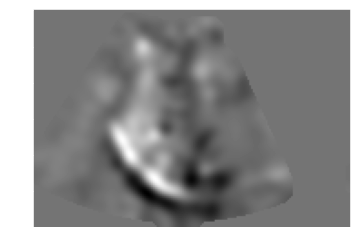

In [4]:
# subtract mean for all pixels
vidStd = []
for vid in videoTransMaskList:
    vidMean=vid-vid.mean(axis=0)
    vidStd.append(vidMean)
    plt.figure()
    plt.imshow(vidMean[0],cmap='gray')

# Setup model

In [5]:
import jax
import jax.numpy as jnp
import numpyro.distributions as dist
from jax import random
import time
from numpyro.infer import MCMC, NUTS, init_to_feasible

In [6]:
# Carry function
def f(carry, noise_t):
  beta, z_prev, tau = carry
  z_t = jnp.matmul(beta,z_prev)+noise_t
  z_prev = z_t
  return (beta, z_prev, tau), z_t

In [7]:
def model(T, T_forecast, output_dim, obs=None,latent_dim=2):

    """
    Define priors over beta, tau, sigma, z_1 (keep the shapes in mind)
    """

    beta = numpyro.sample(name="beta", fn=dist.Normal(loc=jnp.zeros((latent_dim,latent_dim)), scale=jnp.ones((latent_dim,latent_dim))))
    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=jnp.ones(latent_dim)))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=.1))
    z_prev = numpyro.sample(name="z_prev", fn=dist.Normal(loc=jnp.zeros(latent_dim), scale=jnp.ones(latent_dim)))
    h_matrix = numpyro.sample(name="h_matrix", fn=dist.Normal(loc=jnp.ones((output_dim,latent_dim)),scale=1))
    
    """
    Define LKJ prior
    """

    L_Omega = numpyro.sample("L_Omega", dist.LKJCholesky(latent_dim, 1.))
    Sigma_lower = jnp.matmul(jnp.diag(jnp.sqrt(tau)), L_Omega) # lower cholesky factor of the covariance matrix
    noises = numpyro.sample("noises", fn=dist.MultivariateNormal(loc=jnp.zeros(latent_dim), scale_tril=Sigma_lower), sample_shape=(T+T_forecast-1,))
    
    """
    Propagate the dynamics forward using jax.lax.scan
    """

    carry = (beta, z_prev, tau)
    z_collection = [z_prev]
    carry, zs_exp = jax.lax.scan(f, carry, noises, T+T_forecast-1)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    
    """
    Sample the observed y (y_obs) and missing y (y_mis)
    """
    #print('z_col shape', z_collection.shape)
    #print("z2", z_collection[2])
    #print((jnp.matmul(h_matrix, z_collection[:T].T)).T)
    #print("H", h_matrix.shape)
    #print("z", z_collection[:T].T.shape)
    #mu = jnp.matmul(h_matrix, z_collection[:T].T).T
    #print("mu", jnp.nan_to_num(mu))  

    numpyro.sample(name="y_obs", fn=dist.Normal(loc=(jnp.nan_to_num(jnp.matmul(h_matrix, z_collection[:T].T)).T), scale = sigma), obs=obs)
    numpyro.sample(name="y_pred", fn=dist.Normal(loc=(jnp.nan_to_num(jnp.matmul(h_matrix, z_collection[T:].T)).T), scale = sigma), obs=None) 
 

    return z_collection

# Test model with sin curves

In [18]:
#N = 144
#test_x = np.linspace(0,10,N)
#test_y = 40*np.sin(test_x)
#for i in range (1,4):
    #test_y = np.vstack((test_y, 40*np.sin(i/2*test_x) + np.random.normal(0,0.5,N)))


In [ ]:
#t0 = time.time()
#rng_key = random.PRNGKey(0)
#rng_key, rng_key_ = random.split(rng_key)
#nuts_kernel = NUTS(model=model,init_strategy=init_to_feasible())
#mcmc_sin = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000, num_chains=1)
#mcmc_sin.run(rng_key_, T=N, T_forecast=100, output_dim=test_y.T.shape[1], obs=test_y.T)
#t_fin = time.time()
#print("Total time: {0:.3f}m".format((t_fin - t0)/60))

In [ ]:
#mcmc_sin.print_summary()

In [ ]:
#samples = {k:v for k, v in mcmc_sin.get_samples().items()}
#print(samples['y_pred'].shape)

# get mean and standard devitions for predictions
#y_mean = samples["y_pred"][:,:,2].mean(axis=0)
#y_std = samples["y_pred"][:,:,2].std(axis=0)

#y_pred_025 = y_mean - 1.96*y_std
#y_pred_975 = y_mean + 1.96*y_std

#plt.plot(range(N),test_y.T,"bo")
#plt.plot(range(N,N+100),y_mean.T,"rx")
#plt.fill_between(range(N,N+100), y_pred_025, y_pred_975, alpha=0.3)
#plt.legend(["Observed","Forecasted"])
#plt.show()


# Model for videoData

In [24]:
data_input = vidStd[1][:1000,:,:].reshape(1000,-1)


In [25]:

t0 = time.time()
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model,init_strategy=init_to_feasible())
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=data_input.shape[0], T_forecast=300, output_dim=data_input.shape[1], obs=data_input,latent_dim=15)

t_fin = time.time()

print("Total time: {0:.3f}m".format((t_fin - t0)/60))

  0%|          | 0/2000 [00:00<?, ?it/s]2023-05-28 22:47:22.420435: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 4s:

  reduce-window.27 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime.  XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2023-05-28 22:47:23.304041: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 4.885682702s
Constant folding an instruction is taking > 4s:

  reduce-window.27 (displaying the full instruction incurs a runtime overhead. 

In [554]:
samples = {k:v for k, v in mcmc.get_samples().items()}
print(samples['y_pred'].shape)

baseline = videosTransMaskList[0][220:,200:210,200:210]/255
mean_samples = samples["y_pred"].mean(axis=0)
print(mean_samples.shape)
print(baseline.shape)

(1000, 60, 100)
(60, 100)
(60, 10, 10)


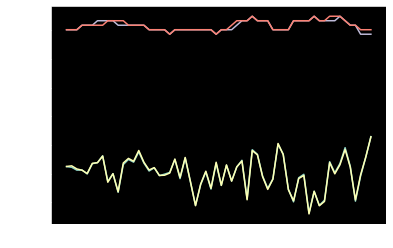

In [555]:
px_values_pred = mean_samples[:,[2,3]]
px_values_base = baseline.reshape(baseline.shape[0],-1)[:,[2,3]]

plt.plot(px_values_pred)
plt.plot(px_values_base)

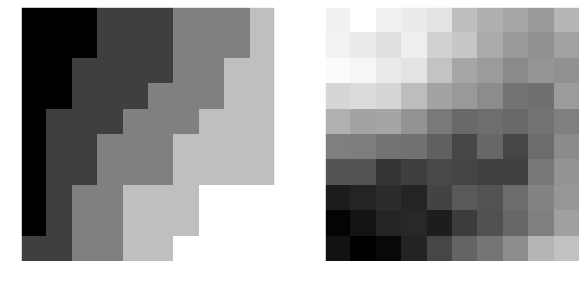

In [564]:
videoIdx = 0 # Choose video to visualize
noFrames = 60 # Choose first noFrames to visualize

if noFrames > videosList[videoIdx].shape[0]:
    noFrames = videosList[videoIdx].shape[0]

vidShow=videosList[videoIdx][:noFrames]

for frame in range(noFrames):
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
    ax1.imshow(baseline[frame,:].reshape(10,10),cmap='gray')
    ax2.imshow(mean_samples[frame].reshape(10,10),cmap='gray')
    plt.show()
    clear_output(wait=True)

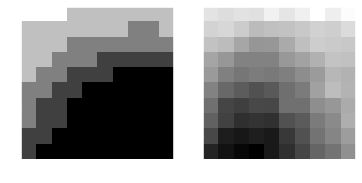

In [568]:
%matplotlib inline
fig,(ax1,ax2) = plt.subplots(1,2)
ax1.imshow(baseline[6,:].reshape(10,10),cmap='gray')
ax2.imshow(mean_samples[6].reshape(10,10),cmap='gray') 
plt.show()

In [570]:
print(mean_samples.shape)
print(baseline.shape)

(60, 100)
(60, 10, 10)


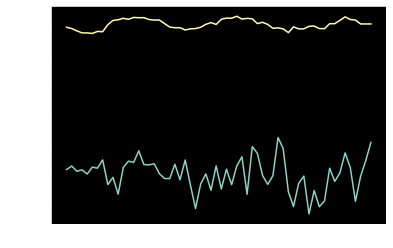

In [573]:
mean_frame_pred = mean_samples.mean(axis=1)
mean_frame_base = baseline.mean(axis=(1,2))

plt.plot(mean_frame_pred)
plt.plot(mean_frame_base)

In [520]:
samples.keys()

dict_keys(['L_Omega', 'beta', 'h_matrix', 'noises', 'sigma', 'tau', 'y_pred', 'z_prev'])

In [524]:
samples['h_matrix'].shape
print(samples['beta'].shape)

(1000, 2, 2)


<AxesSubplot:ylabel='Count'>

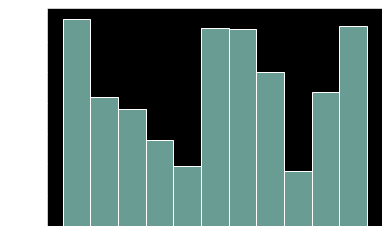

In [534]:
beta = samples['beta']

sns.histplot(beta[:,1,1])

(1000, 25, 2) h_matrix


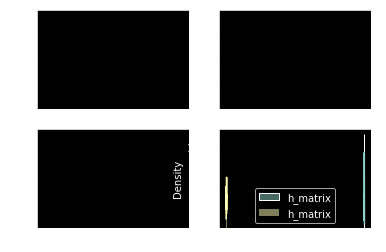

(1000, 2) tau


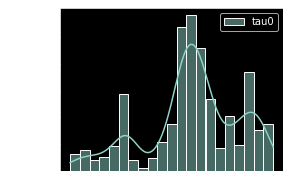

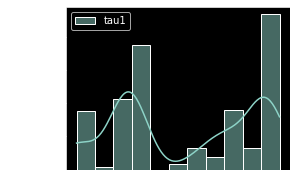

(1000, 2, 2) beta


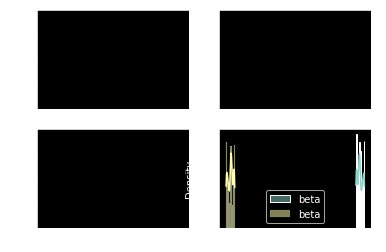

In [522]:
import seaborn as sns
nodes = ["h_matrix", "tau","beta"]
for node in nodes:
  if node in ("tau"):
    print(samples[node].shape,node)
    for i in range(2):
      plt.figure(figsize=(4,3))
      sns.histplot(samples[node][:,i], label=node+"%d"%i, kde=True, stat="density")
      plt.legend()
    plt.show()
  else:
    print(samples[node].shape,node)
    fig, axs = plt.subplots(2,2)
    for i in range(2):
      axs[i] = sns.histplot(samples[node][:,i,i], label=node, kde=True, stat="density")
    plt.legend()
    plt.show()